In [16]:
#Necessary Dependencies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from utils import * 
from glob import glob
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from itertools import chain
from datetime import datetime
import statistics
#DenseNet Dependencies
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [17]:
#HyperParameters
IMG_IND = 224
IMG_SHAPE = (IMG_IND,IMG_IND,3)
IMAGE_SIZE = (IMG_IND,IMG_IND)
BATCH_SIZE = 32
LOSS = BinaryCrossentropy()
SEED = 2
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.2 

In [18]:
#Get dataset from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Brain_Data_Organised/",
    shuffle =  True,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

Found 2501 files belonging to 2 classes.


In [19]:
class_names = dataset.class_names
class_names

['Normal', 'Stroke']

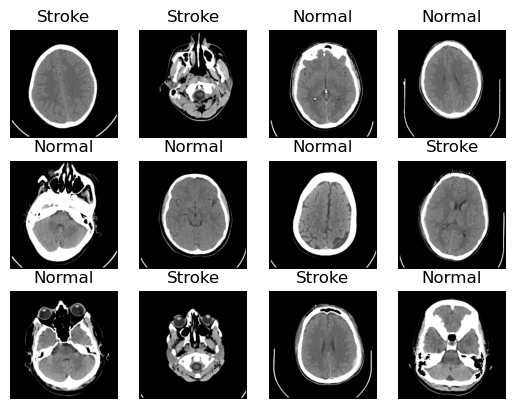

In [20]:
#Data visualiation
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [21]:
# Get the number of samples in the dataset
num_samples = len(dataset)

# Calculate the number of samples for each split
num_validation_samples = int(VALIDATION_SPLIT * num_samples)
num_test_samples = int(TEST_SPLIT * num_samples)
num_train_samples = num_samples - num_validation_samples - num_test_samples

# Split the dataset
train_dataset = dataset.take(num_train_samples)
validation_dataset = dataset.skip(num_train_samples).take(num_validation_samples)
test_dataset = dataset.skip(num_train_samples + num_validation_samples).take(num_test_samples)

print("training_dataset length : ",len(train_dataset))
print("test_dataset length : ",len(test_dataset))
print("validation_dataset length : ",len(validation_dataset))

training_dataset length :  57
test_dataset length :  15
validation_dataset length :  7


In [22]:
#Prefetch and cache the datasets for better performance
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
def get_callbacks():
    callbacks = []
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model.DenseNet.h5', verbose=1, monitor='val_loss')
    callbacks.append(checkpoint)
    annee = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0000001, min_delta=0.00001, mode='auto')
    callbacks.append(annee)
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    callbacks.append(earlystop)
    
    return callbacks

In [10]:
#Dense Net Model
OPTIMIZER = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

# Set the last 10 layers to be trainable
for layer in base_model.layers[:-10]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid', name='Final')(x)
model = Model(inputs=base_model.input, outputs= predictions)

model.compile(loss = 'binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.SpecificityAtSensitivity(0.5)])

In [11]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

__________________________________________________________________________________________________
None


In [12]:
callbacks = get_callbacks()
history = model.fit(
    train_dataset,
    epochs = 50,
    validation_data = validation_dataset,
    callbacks = [callbacks]
)

Epoch 1/50
57/57 [==============================] - ETA: 0s - loss: 0.5571 - accuracy: 0.7078 - precision: 0.6779 - recall: 0.4587 - specificity_at_sensitivity: 0.8333
Epoch 1: saving model to model.DenseNet.h5
57/57 [==============================] - 147s 2s/step - loss: 0.5571 - accuracy: 0.7078 - precision: 0.6779 - recall: 0.4587 - specificity_at_sensitivity: 0.8333 - val_loss: 1.1466 - val_accuracy: 0.6607 - val_precision: 1.0000 - val_recall: 0.0130 - val_specificity_at_sensitivity: 0.8435 - lr: 0.0010
Epoch 2/50
57/57 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.8690 - precision: 0.8646 - recall: 0.7821 - specificity_at_sensitivity: 0.9831
Epoch 2: saving model to model.DenseNet.h5
57/57 [==============================] - 126s 2s/step - loss: 0.3452 - accuracy: 0.8690 - precision: 0.8646 - recall: 0.7821 - specificity_at_sensitivity: 0.9831 - val_loss: 0.7470 - val_accuracy: 0.7098 - val_precision: 1.0000 - val_recall: 0.1558 - val_specificity_at_sensi

Epoch 17/50
57/57 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity_at_sensitivity: 1.0000
Epoch 17: saving model to model.DenseNet.h5
57/57 [==============================] - 158s 3s/step - loss: 0.0017 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity_at_sensitivity: 1.0000 - val_loss: 0.0236 - val_accuracy: 0.9911 - val_precision: 0.9747 - val_recall: 1.0000 - val_specificity_at_sensitivity: 1.0000 - lr: 0.0010
Epoch 18/50
57/57 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity_at_sensitivity: 1.0000
Epoch 18: saving model to model.DenseNet.h5
57/57 [==============================] - 158s 3s/step - loss: 0.0016 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity_at_sensitivity: 1.0000 - val_loss: 0.0228 - val_accuracy: 0.9911 - val_precision: 0.9747 - val_recall: 1.0000 - val_specificity_at_s

Epoch 33/50
57/57 [==============================] - ETA: 0s - loss: 6.1685e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity_at_sensitivity: 1.0000
Epoch 33: saving model to model.DenseNet.h5
57/57 [==============================] - 130s 2s/step - loss: 6.1685e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity_at_sensitivity: 1.0000 - val_loss: 0.0202 - val_accuracy: 0.9955 - val_precision: 0.9872 - val_recall: 1.0000 - val_specificity_at_sensitivity: 1.0000 - lr: 2.5000e-04
Epoch 34/50
57/57 [==============================] - ETA: 0s - loss: 6.0476e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity_at_sensitivity: 1.0000
Epoch 34: saving model to model.DenseNet.h5
57/57 [==============================] - 140s 2s/step - loss: 6.0476e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity_at_sensitivity: 1.0000 - val_loss: 0.0202 - val_accuracy: 0.9955 - val_precision: 0.9872 - val_recall: 1.0000 - 

Epoch 49/50
57/57 [==============================] - ETA: 0s - loss: 5.3476e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity_at_sensitivity: 1.0000
Epoch 49: saving model to model.DenseNet.h5
57/57 [==============================] - 141s 2s/step - loss: 5.3476e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity_at_sensitivity: 1.0000 - val_loss: 0.0203 - val_accuracy: 0.9955 - val_precision: 0.9872 - val_recall: 1.0000 - val_specificity_at_sensitivity: 1.0000 - lr: 3.1250e-05
Epoch 50/50
57/57 [==============================] - ETA: 0s - loss: 5.3276e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity_at_sensitivity: 1.0000
Epoch 50: saving model to model.DenseNet.h5
57/57 [==============================] - 133s 2s/step - loss: 5.3276e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity_at_sensitivity: 1.0000 - val_loss: 0.0203 - val_accuracy: 0.9955 - val_precision: 0.9872 - val_recall: 1.0000 - 

In [23]:
model = tf.keras.models.load_model("./model.DenseNet.h5")

In [24]:
scores = model.evaluate(test_dataset)

15/15 [==============================] - 34s 2s/step - loss: 0.0143 - accuracy: 0.9956 - precision: 0.9945 - recall: 0.9945 - specificity_at_sensitivity: 1.0000


In [25]:
print("loss: ", scores[0])
print("accuracy: ", scores[1])

loss:  0.014337191358208656
accuracy:  0.9955849647521973


In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

NameError: name 'history' is not defined

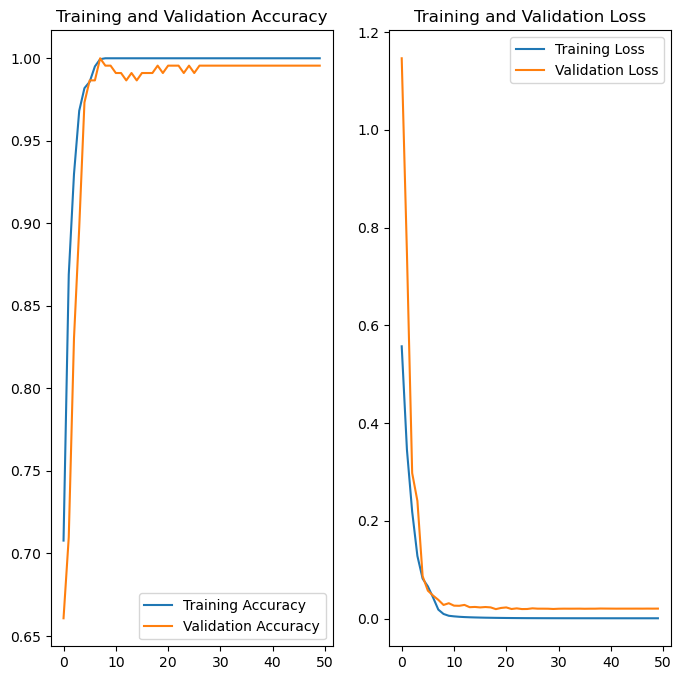

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Normal
1/1 [==============================] - 4s 4s/step
predicted label: Normal


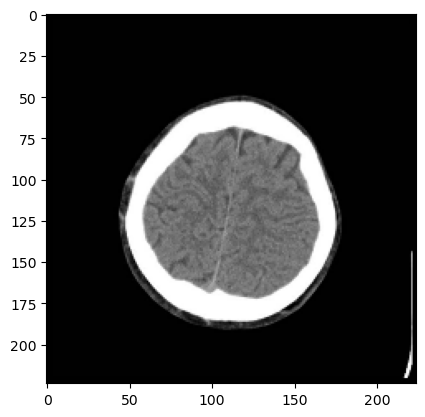

In [27]:
for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [28]:
#Write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[1] if predictions[0] >= 0.5 else class_names[0]
    confidence = round(100 * (predictions[0][0] if predictions[0] >= 0.5 else 1 - predictions[0][0]), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 115ms/step


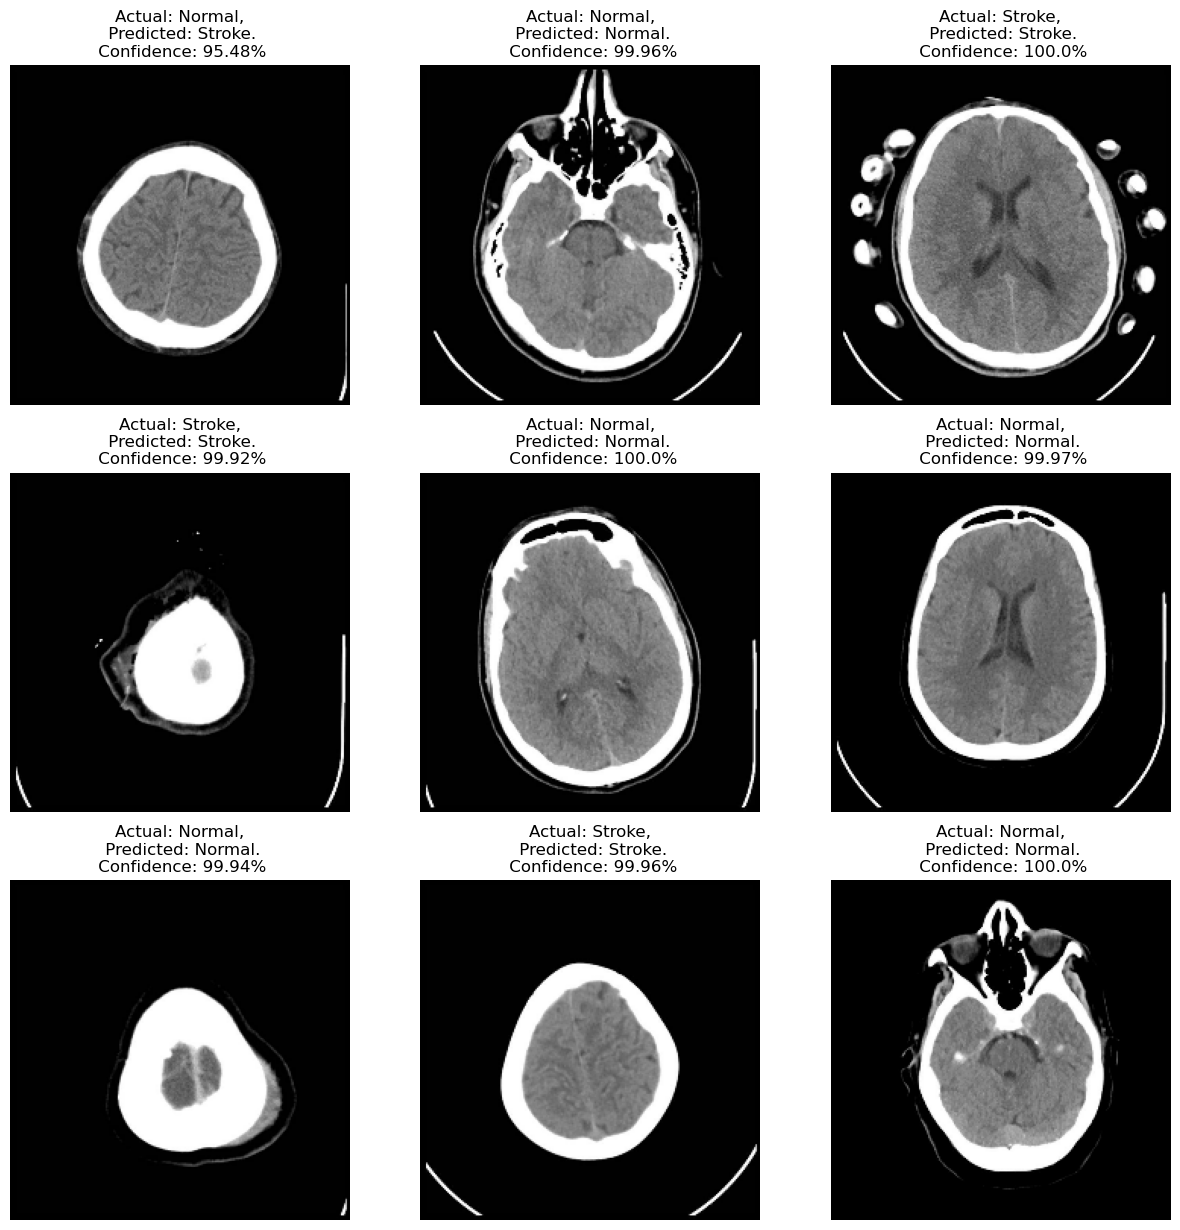

In [30]:
#run inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [24]:
#Saving the Model
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [25]:
model.save("../DenseNet.h5")